In [2]:
!pip3 install requests


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [143]:
!pip3 install yellowbrick


[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 282.6/282.6 kB 4.4 MB/s eta 0:00:00


In [255]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

In [84]:
# Download  csv file
# url_to_csv_file = "https://raw.githubusercontent.com/amankharwal/Website-data/master/marketing_campaign.csv"
# save_with_filename = "D:/customer-segmentation-and-predictive-analysis/marketing_camp.csv"

# reponse = requests.get(url_to_csv_file)

# with open(save_with_filename, 'wb') as file:
#     file.write(reponse.content)

# print(f'csv file is saved at {save_with_filename}')


In [85]:
df = pd.read_csv("marketing_camp.csv", delimiter = ';')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [86]:
df.loc[:, 'Dt_Customer'] = pd.to_datetime(df["Dt_Customer"])

C:\Users\ganes\AppData\Local\Temp\ipykernel_1504\4261289699.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Dt_Customer'] = pd.to_datetime(df["Dt_Customer"])


## EDA

In [87]:
df.shape

(2240, 29)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2240 non-null   int64         
 1   Year_Birth           2240 non-null   int64         
 2   Education            2240 non-null   object        
 3   Marital_Status       2240 non-null   object        
 4   Income               2216 non-null   float64       
 5   Kidhome              2240 non-null   int64         
 6   Teenhome             2240 non-null   int64         
 7   Dt_Customer          2240 non-null   datetime64[ns]
 8   Recency              2240 non-null   int64         
 9   MntWines             2240 non-null   int64         
 10  MntFruits            2240 non-null   int64         
 11  MntMeatProducts      2240 non-null   int64         
 12  MntFishProducts      2240 non-null   int64         
 13  MntSweetProducts     2240 non-nul

## What to do we Null/Missing Values?
Check the null values in different columns, if neccesary check the percentage of null values available per column. Based on that decide the stragies where to drop null values or should be fill the null/missing values with median, mode or mean. Note that the mean is more sensitive to the outliers, so median can be used to fill the missing values. If null values are less than 10% of the overall data size then we will use strategy to drop them direcly.

In [89]:
# check the null values
def plot_missing(dataframe):
    null_values = pd.DataFrame(dataframe.isnull().sum(),index = None)
    null_values.reset_index(inplace = True)

    # rename the columns
    null_values.columns = ['col_name', 'missing_count']
    condition = (null_values.iloc[:,1] != 0) 
    percent_missing = (null_values[condition]['missing_count'].sum() / dataframe.shape[0]) * 100
    print(f"The dataframe contain only {round(percent_missing,2)}% of missing values")
    
    plt.figure(figsize = ( 20,  6))
    plt.bar(null_values['col_name'], null_values['missing_count'])
    plt.xticks(rotation = 30)
    plt.xlabel("Column Names")
    plt.ylabel("Number of Missing Values")
    plt.title("Column vs Missing Values")
    plt.plot()

    return None



The dataframe contain only 1.07% of missing values


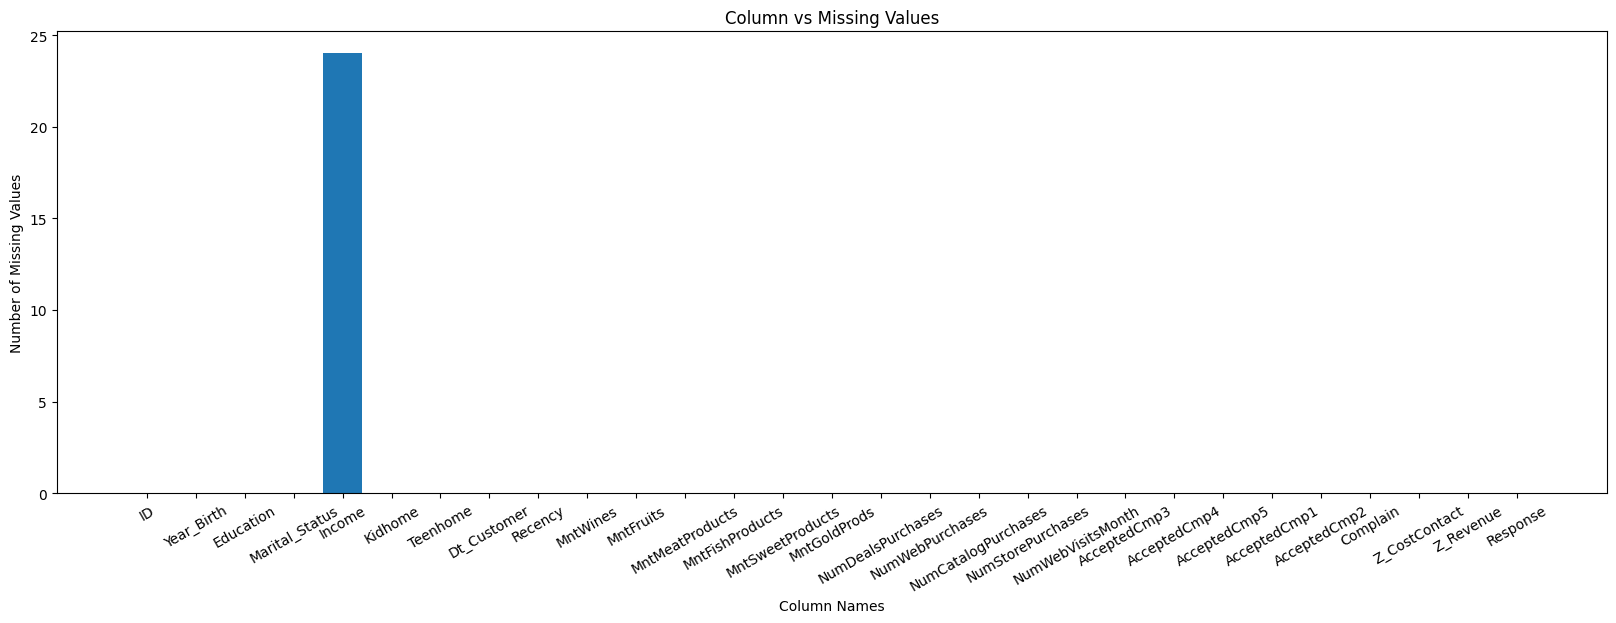

In [90]:
# call the function
plot_missing(df)

## Understand the bar plot
It shows only a income column has null values, we could have understand it easy from data frame but ploting the bar chart is always a best practice. So as only single column has missing values and statistically data conatin only 1% missing values so we will drop it directly.

In [91]:
# drop missing value (rows)
df = df.dropna(axis = 0)

C:\Users\ganes\AppData\Local\Temp\ipykernel_1504\1531109476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


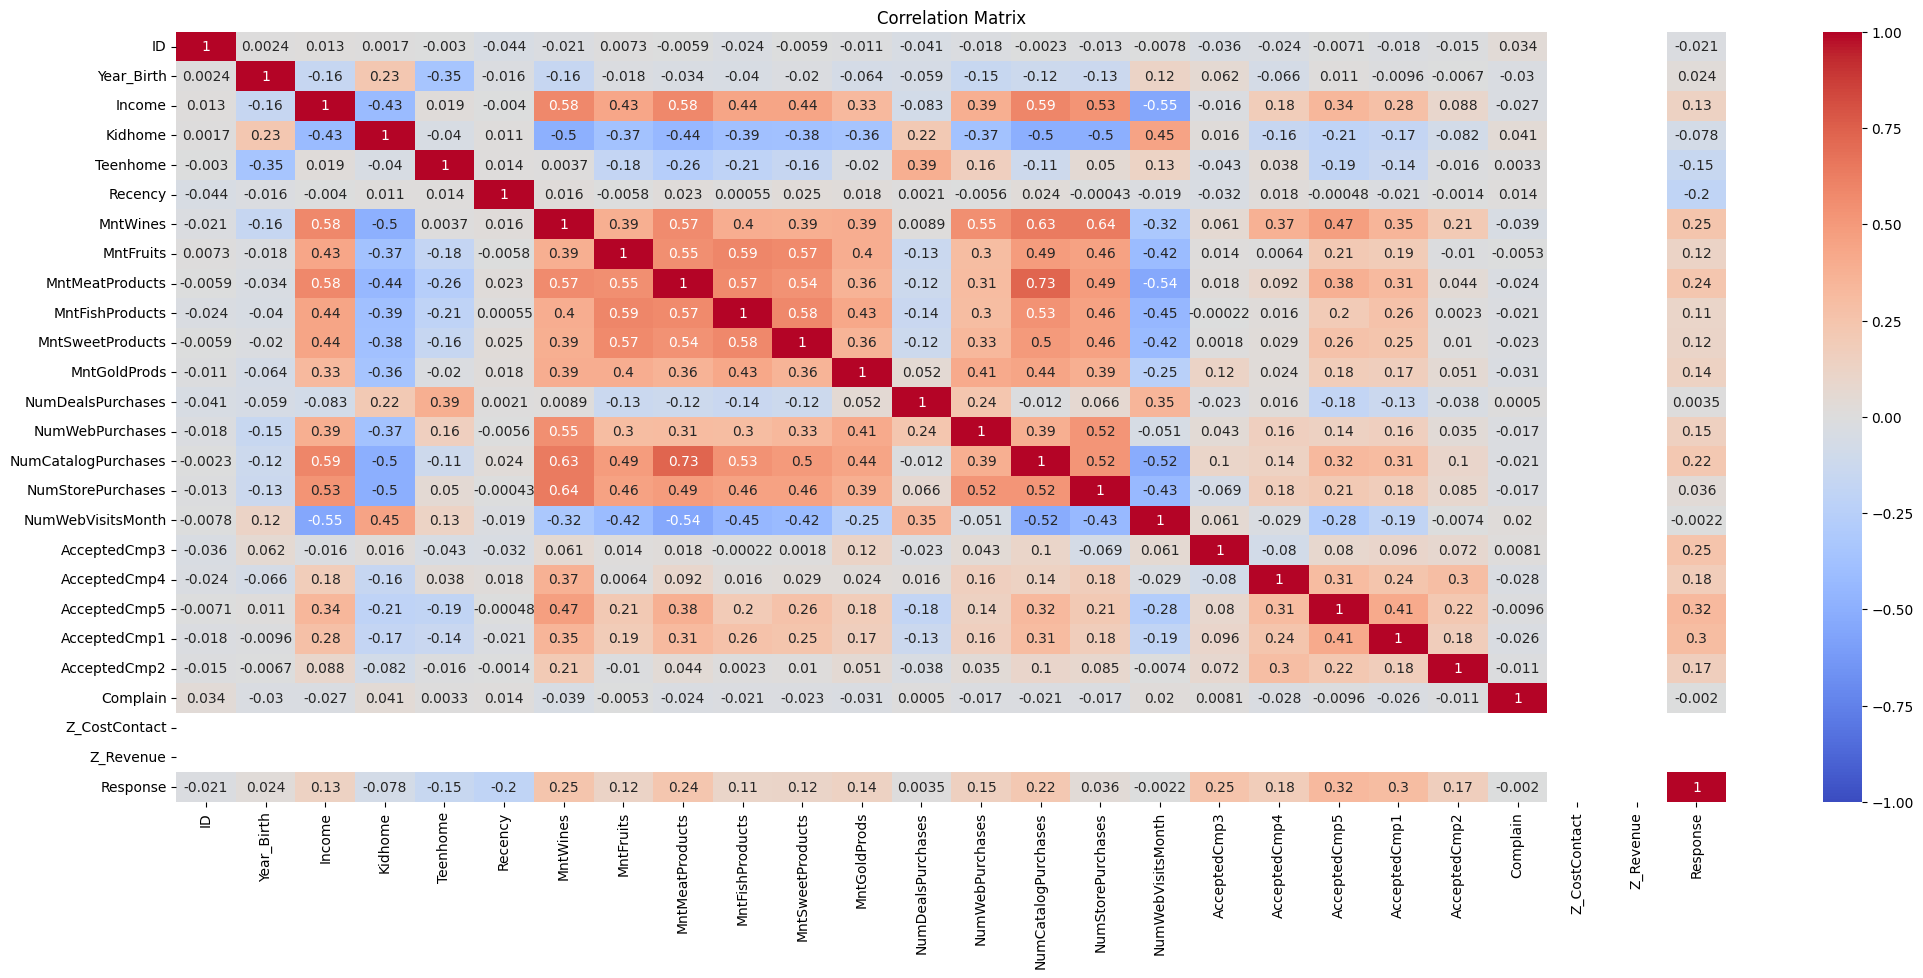

In [92]:
# let see how columns are correlated with eachother
corr_matrix = df.corr()
plt.figure(figsize=(25, 10))  # Optional: Set the size of the plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

## What does this correlation Matrix show?
By looking at correlation matrix we can have idea about the how different columns are correlated with each other or in other words how linear they are related. Red color show the correlation of column with itself, as the color become dull the correlation becomes weaker. The gray cells shows either very low value or negative values which show the weaker correlation between the columns. Light and Dark Blue cells shows the negative correlation between the columns.

One More find is that Z_CostContact and Z_Revenue has no correlation with other columns and with themselves as well. Which means we can easily drop them.

## Why correlation Matrix is important?
Now we have understood the meaning information about correlation between different columns. By simply looking at matrix we understood that whether we have to drop few columns or not, also we understood shall we perform the diamensional reduction or not. We have answers to this questions.

## Outcome
We can drop Z_CostContact and Z_Revenue columns.

We can perform PCA so that we can procced with only relevent information only.

# Let see how positive and negative correlation look like.

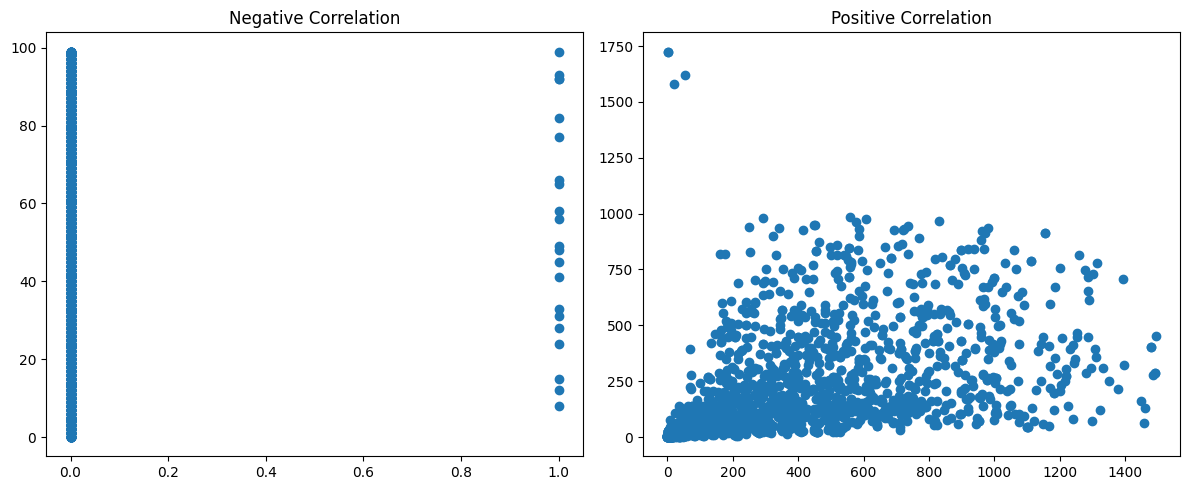

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(df["Complain"], df["Recency"])
axes[0].set_title('Negative Correlation')
axes[1].scatter(df["MntWines"],df["MntMeatProducts"])
axes[1].set_title('Positive Correlation')
plt.tight_layout()
plt.show()

In [94]:
df = df.drop(['Z_CostContact' ,'Z_Revenue'], axis =1)

# Understand the data distribution


<AxesSubplot:>

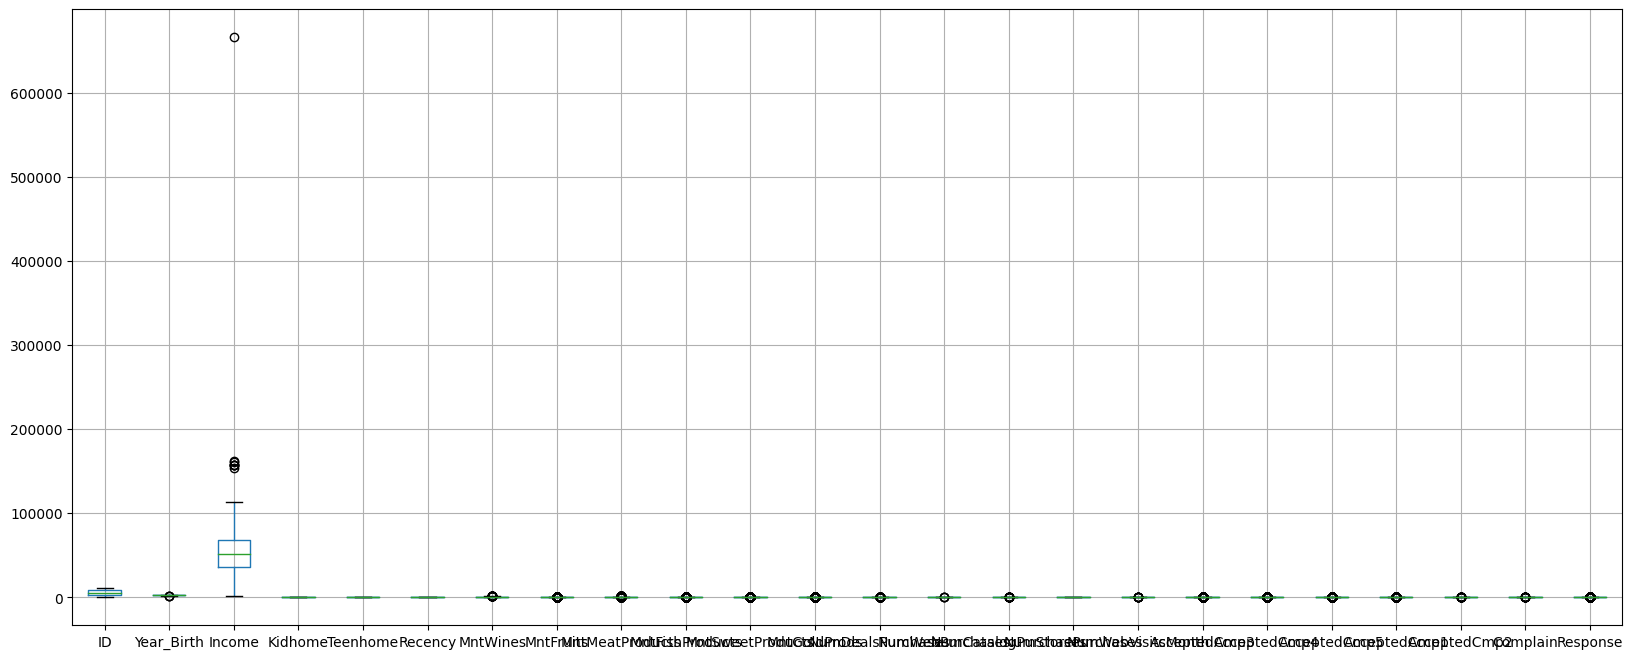

In [95]:
df.boxplot(figsize = (20,8))


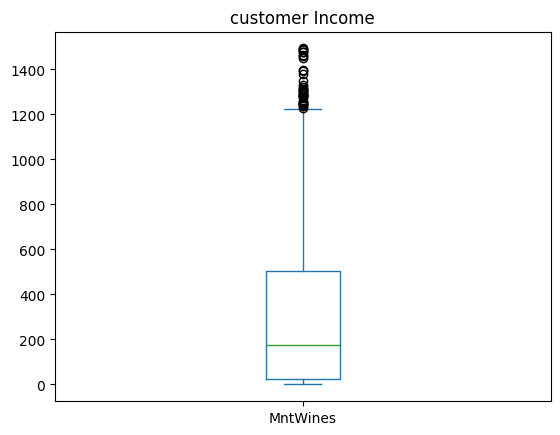

In [96]:
df["MntWines"].plot(kind = 'box', title = 'customer Income')
plt.show()

# What do we understand from this ?
There are outlier in the data, outlier are the data points above upper limit and below lower limit. There can be different approches to see how effetive removing outlier is. One way is to procced without outlier and other way is to remove outliers and proceed.

In [97]:
# let consider all the columns except Dt_customer
cols = list(df.columns)
rem = ['Dt_Customer', "Marital_Status", "Education"]
for i in rem:
    cols.remove(i)

# Count the outliers and plot them

In [98]:
outlier_count = {}
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count[col] = len(outliers)
outlier_count

{'ID': 0,
 'Year_Birth': 3,
 'Income': 8,
 'Kidhome': 0,
 'Teenhome': 0,
 'Recency': 0,
 'MntWines': 35,
 'MntFruits': 246,
 'MntMeatProducts': 174,
 'MntFishProducts': 222,
 'MntSweetProducts': 246,
 'MntGoldProds': 205,
 'NumDealsPurchases': 84,
 'NumWebPurchases': 3,
 'NumCatalogPurchases': 23,
 'NumStorePurchases': 0,
 'NumWebVisitsMonth': 8,
 'AcceptedCmp3': 163,
 'AcceptedCmp4': 164,
 'AcceptedCmp5': 162,
 'AcceptedCmp1': 142,
 'AcceptedCmp2': 30,
 'Complain': 21,
 'Response': 333}

[]

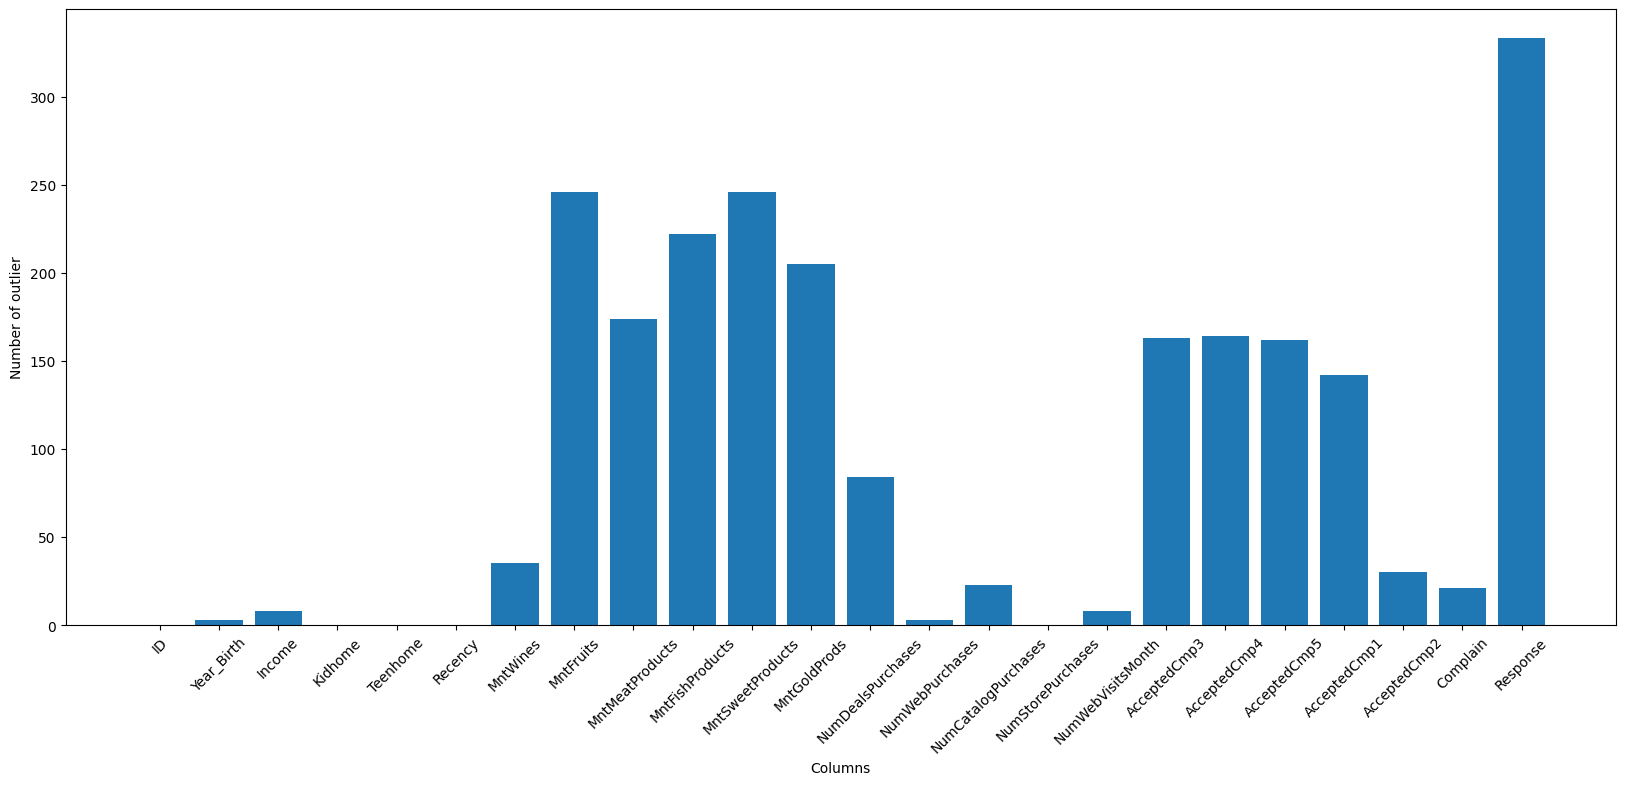

In [99]:
plt.figure(figsize=(20,8))
plt.bar(list(outlier_count.keys()),list(outlier_count.values()))
plt.xticks(rotation = 45)
plt.xlabel("Columns")
plt.ylabel("Number of outlier")
plt.plot()

        

# Label Encoding

In [100]:
marital_status_mapping = {
    "Married": "Couple",
    "Together": "Couple",
    "Single": "Single",
    "Divorced": "Single",
    "Widow": "Single",
    "Alone": "Single",
    "Absurd": "Single",
    "YOLO": "Single"
}

df['Marital_Status'] = df['Marital_Status'].map(marital_status_mapping)

total_adults_mapping = {
    "Couple": 2,
    "Single": 1
}
df['Total_adults'] = df['Marital_Status'].map(total_adults_mapping)



df['Education'].replace('2n Cycle', 'Master', inplace=True)

label_map = {'Basic': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}
df['Education_encode'] = df['Education'].map(label_map)

# Feature Engineering

Feature Engineering is the one of the technique where we try to formulate features by adding, substracting

In [101]:
# calculate customers age
df["Customer_Age"] = datetime.now().year - df['Year_Birth']

# every customer spend money on different things, how much will be total spend
df['Total_spend'] = df['MntWines'] + df['MntFishProducts'] + df['MntFruits'] + df['MntMeatProducts'] +df['MntSweetProducts'] + df['MntGoldProds']

# Total purchase
df['Total_purchase'] = df['NumDealsPurchases'] + df['NumCatalogPurchases'] + df['NumWebPurchases'] + df['NumStorePurchases']

# Total children
df['Total_chil'] = df['Kidhome'] + df['Teenhome']

df['accepted_camp'] = df['AcceptedCmp1'] +df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] + df['Complain'] + df['Response']

In [102]:
# Get the current year
current_year = datetime.now().year

# Extract the year from 'Dt_Customer' and subtract from the current year
df['Customer_Since_Years'] = current_year - pd.to_datetime(df['Dt_Customer']).dt.year

In [103]:
df['Family_size'] = df['Total_adults'] + df['Total_chil']

In [104]:
df1 = df.copy()
df2 = df.copy()
df3 = df.copy()

In [105]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,Total_adults,Education_encode,Customer_Age,Total_spend,Total_purchase,Total_chil,accepted_camp,Customer_Since_Years,Family_size
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1,1,2,66,1617,25,0,1,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,1,2,69,27,6,2,0,9,3
2,4141,1965,Graduation,Couple,71613.0,0,0,2013-08-21,26,426,...,0,2,2,58,776,21,0,0,10,2
3,6182,1984,Graduation,Couple,26646.0,1,0,2014-02-10,26,11,...,0,2,2,39,53,8,1,0,9,3
4,5324,1981,PhD,Couple,58293.0,1,0,2014-01-19,94,173,...,0,2,4,42,422,19,1,0,9,3


# Remove Outliers

In [110]:
df = df.drop(['Dt_Customer', 'Education', 'Marital_Status'],axis=1)

In [111]:
t_col = list(df.columns)

Q1 = df[t_col].quantile(0.25)
Q3 = df[t_col].quantile(0.75)
IQR = Q3 - Q1

#generatlly data points which fall below (Q1 - 1.5 * IQR)  and above (Q3 + 1.5 * IQR) are consider to be the outliers
df_wt_outliers = df[~((df[t_col] < (Q1 - 1.5 * IQR)) | (df[t_col] > (Q3 + 1.5 * IQR))).any(axis=1)]

We have performed feature engineering, we can remove the those columns

In [112]:
rem_col = ['Year_Birth','MntWines','MntFishProducts' ,'MntFruits' ,'MntMeatProducts', 'MntSweetProducts','Kidhome','Teenhome','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4' ,'AcceptedCmp5','Complain','Response','NumDealsPurchases','MntGoldProds',	'NumWebPurchases',	'NumCatalogPurchases',	'NumStorePurchases',	'NumWebVisitsMonth']

In [113]:
df_outlier = df_wt_outliers.drop(rem_col,axis=1)

In [114]:
df_outlier.head()

,ID,Income,Recency,Total_adults,Education_encode,Customer_Age,Total_spend,Total_purchase,Total_chil,accepted_camp,Customer_Since_Years,Family_size
2,4141,71613.0,26,2,2,58,776,21,0,0,10,2
5,7446,62513.0,16,2,3,56,716,22,1,0,10,3
7,6177,33454.0,32,2,4,38,169,10,1,0,10,3
13,8180,59354.0,53,1,3,71,310,15,2,0,10,3
25,7892,18589.0,89,1,2,54,75,8,0,0,10,1


In [116]:
df_outlier.shape

(630, 12)

In [117]:
df_filter = df.drop(rem_col,axis=1)

In [118]:
df_filter.shape

(2216, 12)

In [121]:
df_original = df.drop(columns=['ID', 'Year_Birth','Kidhome',
       'Teenhome'],axis=1) 

In [124]:
# we have three different dataframes which are used to calculate the variance.

print(f'Shape of original version of df: {df_original.shape}') 
print(f'Shape of filtered version of df: {df_filter.shape}') 
print(f'Shape of filter and withoutoulier version of df: {df_outlier.shape}') 

Shape of original version of df: (2216, 29)
Shape of filtered version of df: (2216, 12)
Shape of filter and withoutoulier version of df: (630, 12)


## PCA

PCA is a technique for dimensionality reduction that identifies a set of orthogonal axes, called principal components, that capture the maximum variance in the data. The principal components are linear combinations of the original variables in the dataset and are ordered in decreasing order of importance. The total variance captured by all the principal components is equal to the total variance in the original dataset.

Yet We don't know how effective will be the PCA. Let see through implementation how effective is PCA. Here we will form different dataframes which will be copy of original one. we can also test effect of removing outliers.

So we will use three different dataframes, df = original, df_rm_outlier = df_without outlier, df_filtered = remove few components. To evaluate this we will use the variance ration which will explain the information about the captured varience. 
![PCA](PCA.png)

In [125]:
# normalization of data

scaler = StandardScaler()

# Standardize the df features 
df_scaled = scaler.fit_transform(df_original)
# standardize the df_filtered features 
df_filtered_scaled = scaler.fit_transform(df_filter)
df_outlier_scaled = scaler.fit_transform(df_outlier)


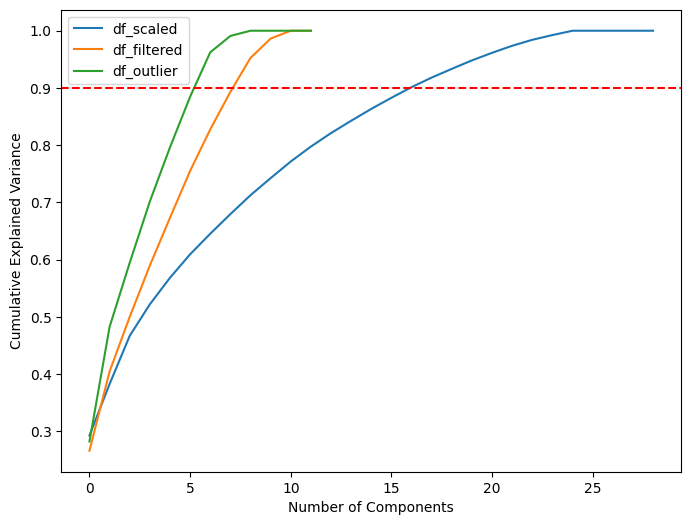

In [128]:
# PCA objects for the different dataframes
pca1 = PCA()
pca2 = PCA()
pca3 = PCA()

# apply the PCA on each dataframe
pca1.fit(df_scaled)
pca2.fit(df_filtered_scaled)
pca3.fit(df_outlier_scaled)

# each pca has the variance ratio to understand how good the information has been captured using pca we will perform following
cumulative_explained_variance_scaled = np.cumsum(pca1.explained_variance_ratio_)
cumulative_explained_variance_filtered_scaled = np.cumsum(pca2.explained_variance_ratio_)
cumulative_explained_variance_outlier_scaled = np.cumsum(pca3.explained_variance_ratio_)


# plot the cumulative score 
plt.figure(figsize=(8,6))
plt.plot(range(len(cumulative_explained_variance_scaled)), cumulative_explained_variance_scaled, label='df_scaled')

# Plot the cumulative explained variance for df_filtered_scaled
plt.plot(range(len(cumulative_explained_variance_filtered_scaled)), cumulative_explained_variance_filtered_scaled, label='df_filtered')
plt.plot(range(len(cumulative_explained_variance_outlier_scaled)), cumulative_explained_variance_outlier_scaled, label='df_outlier')

plt.axhline(y=0.9, color='r', linestyle='--')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.show()


# What does this curves are?

x- axis is number of principle componnets, y-axis is total variance. cumulative expalined variance 1 means, 100% percent of the infomation from the data is explained, do you notice how many principle componnets needed to expalin 100% variance ? Its equal to number of columns different dataframe has.

To captue 80% variance from the data, the df_scaled needs 11 to 12 principle componnets, the df_filtered needs 5-6 principle componnets and df_outliers needs 4 principle componnets.

In [132]:
# Create two PCA objects
pca1 = PCA(n_components=12)
pca2 = PCA(n_components=6)
pca3 = PCA(n_components=4)

# apply the PCA on each dataframe
df_scaled_pca = pca1.fit_transform(df_scaled)
df_filtered_pca = pca2.fit_transform(df_filtered_scaled)
df_outlier_pca = pca3.fit_transform(df_outlier_scaled)

# each pca has the variance ratio to understand how good the information has been captured using pca we will perform following
explained_variance_ratio_scaled = pca1.explained_variance_ratio_
explained_variance_ratio_filtered_scaled = pca2.explained_variance_ratio_
explained_variance_ratio_filtered_scaled = pca3.explained_variance_ratio_

print("Explained Variance Ratio for df_scaled:")
print(explained_variance_ratio_scaled)
print()

print("Explained Variance Ratio for df_filtered_scaled:")
print(explained_variance_ratio_filtered_scaled)
print()

print("Explained Variance Ratio for df_outlier:")
print(explained_variance_ratio_filtered_scaled)
print()

Explained Variance Ratio for df_scaled:
[0.29253079 0.08993116 0.08423192 0.0551001  0.04642186 0.040978
 0.03592186 0.03433705 0.03305135 0.0298387  0.02907132 0.02603479]

Explained Variance Ratio for df_filtered_scaled:
[0.28199363 0.20037262 0.11205553 0.10713904]

Explained Variance Ratio for df_outlier:
[0.28199363 0.20037262 0.11205553 0.10713904]



# What does mean this scores?
Explained Variance Ratio for df_scaled:
[0.29253079 0.08993116 0.08423192 0.0551001  0.04642196 0.04097762
 0.03592223 0.0343364  0.03304987 0.02983776 0.02906366 0.02604019] 
 
 Explained Variance Ratio for df_filtered_scaled:
[0.28199363 0.20037262 0.11205553 0.10713904]

Explained Variance Ratio for df_outlier:
[0.28199363 0.20037262 0.11205553 0.10713904] 

This explains the varianced captured by the individual principle componnets of pca1,pca2,pca3.

Looking at values I can easlilt underand that principle componnets of df_filtered_scaled and df_outlier have captured more variance then df_scaled.

So we will use df_oulier for further use.


In [149]:
df_filtered_scaled.shape

(2216, 12)

In [154]:
df_outlier.shape

(630, 12)

In [155]:
pca_df1 = pd.DataFrame(df_scaled_pca,columns=[f"PC{i+1}" for i in range(df_scaled_pca.shape[1])])
pca_df2 = pd.DataFrame(df_filtered_pca,columns=[f"PC{i+1}" for i in range(df_filtered_pca.shape[1])])
pca_df3 = pd.DataFrame(df_outlier_pca,columns=[f"PC{i+1}" for i in range(df_outlier_pca.shape[1])])

df_filtered_scaled = pd.DataFrame(df_filtered_scaled, columns=df_filter.columns)
df_outlier_scaled = pd.DataFrame(df_outlier_scaled, columns=df_outlier.columns)
df_scaled = pd.DataFrame(df_scaled, columns=df_original.columns)



# Clustering

Algorithm 1: Kmeans

Algorithm 2: Hierarchical Clustering

Algorithm 3: DBSCAN

In [156]:
# get shape of different dataframes 
print(f'The shape of scaled verison of original dataset: {df_scaled.shape}')
print(f'The shape of scaled verison of filtered scaled dataset: {df_filtered_scaled.shape}')
print(f'The shape of scaled verison of outlier scaled  dataset: {df_outlier_scaled.shape}')

print(f'pca1: for df_scaled is {pca_df1.shape}')
print(f'pca1: for df_filter_scaled is {pca_df2.shape}')
print(f'pca1: for df_ouliter_scaled is {pca_df3.shape}')

The shape of scaled verison of original dataset: (2216, 29)
The shape of scaled verison of filtered scaled dataset: (2216, 12)
The shape of scaled verison of outlier scaled  dataset: (630, 12)
pca1: for df_scaled is (2216, 12)
pca1: for df_filter_scaled is (2216, 6)
pca1: for df_ouliter_scaled is (630, 4)


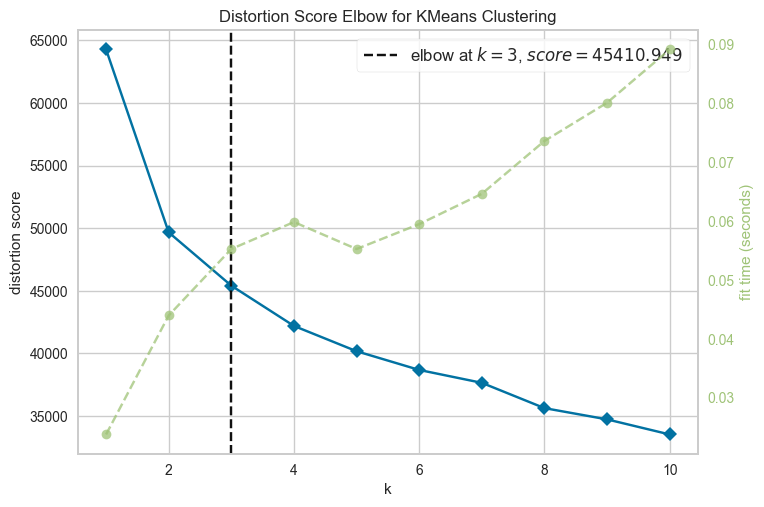

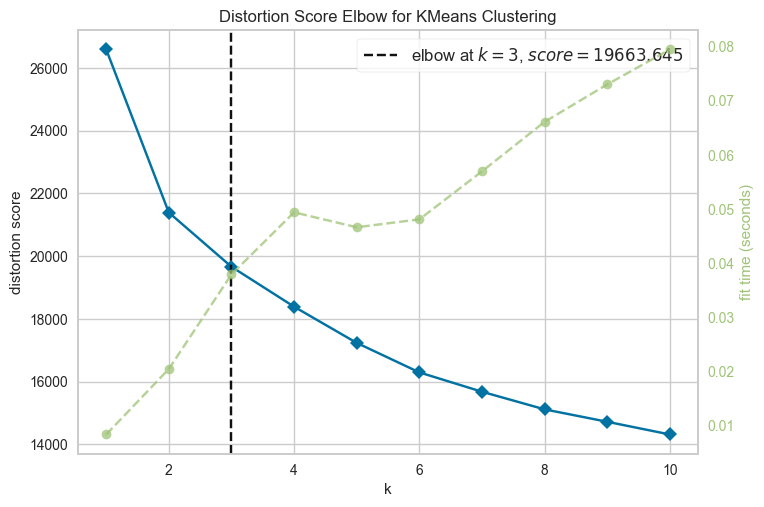

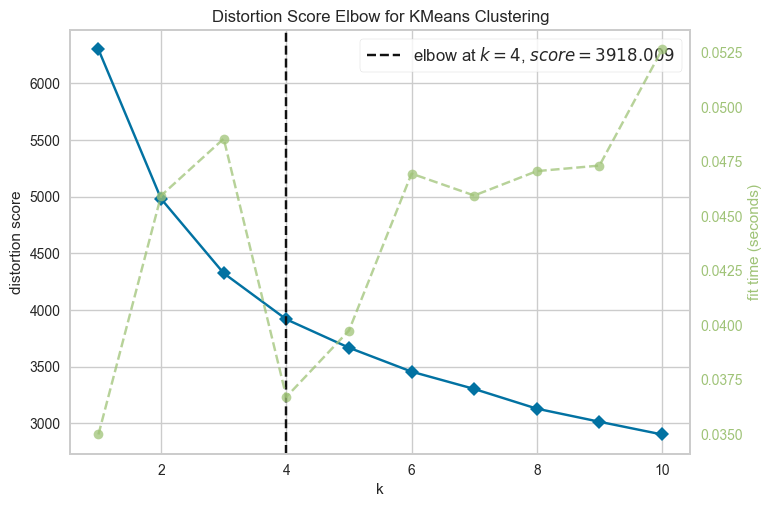

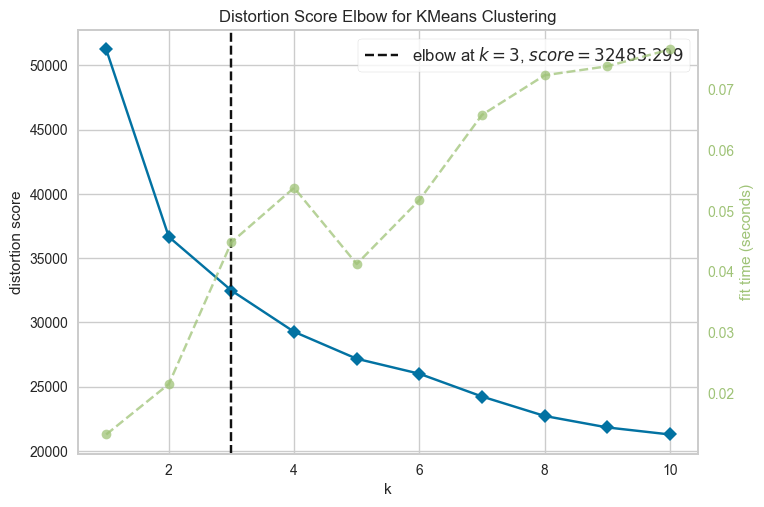

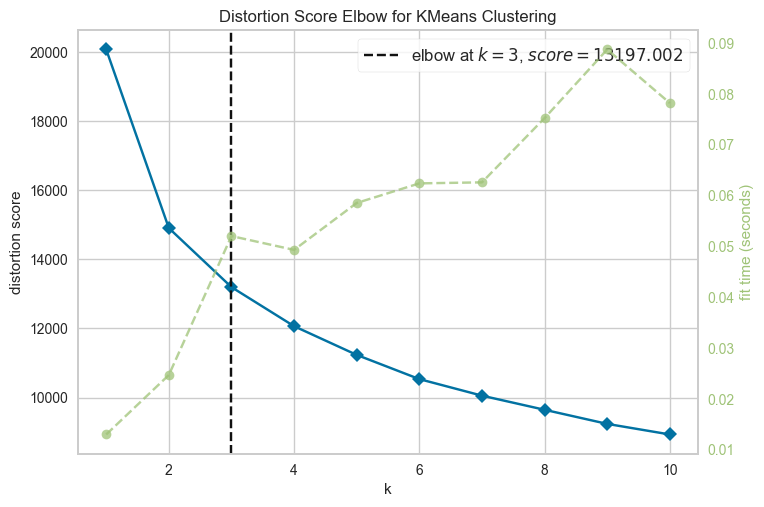

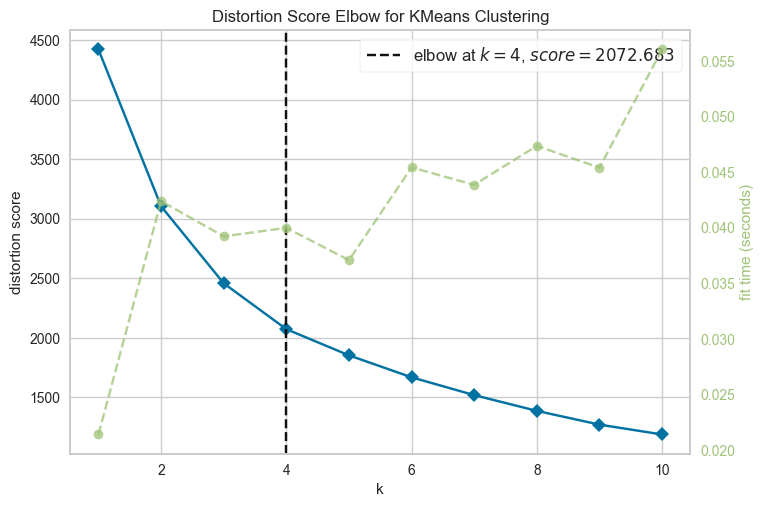

In [157]:
# Create a dictionary with your dataframes
dataframes = {
    'df_scaled': df_scaled,
    'df_filtered_scaled': df_filtered_scaled,
    'df_outlier_scaled': df_outlier_scaled,
    'pca1_df': pca_df1,
    'pca2_df': pca_df2,
    'pca3_df': pca_df3
}

for name, df in dataframes.items():
    model = KMeans( max_iter=300, n_init=10, random_state=0)
    visualizer = KElbowVisualizer(model, k=(1,11))

    visualizer.fit(df)  
    
    visualizer.show()  

For determining  K(numbers of clusters) we use Elbow method.  Elbow Method is a technique that we use to determine the number of centroids(k) to use in a k-means clustering algorithm. 
We will choose the majority so k = 3

In [161]:
for name, df in dataframes.items():
    model = KMeans(n_clusters=3, max_iter=300, n_init=10, random_state=9)
    y_means = model.fit_predict(df)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.loc[y_means == 0, df.columns[0]], y=df.loc[y_means == 0, df.columns[1]], 
                             mode='markers', name='Cluster 1'))
    fig.add_trace(go.Scatter(x=df.loc[y_means == 1, df.columns[0]], y=df.loc[y_means == 1, df.columns[1]], 
                             mode='markers', name='Cluster 2'))
    fig.add_trace(go.Scatter(x=df.loc[y_means == 2, df.columns[0]], y=df.loc[y_means == 2, df.columns[1]], 
                             mode='markers', name='Cluster 3'))
    fig.add_trace(go.Scatter(x=model.cluster_centers_[:, 0], y=model.cluster_centers_[:, 1], 
                             mode='markers', name='Centroids', marker=dict(size=12, line=dict(width=2,color='DarkSlateGrey'))))
    
    fig.update_layout(title=f'Clusters for {name}', 
                      xaxis=dict(title='Feature 1' if 'pca' not in name else 'Principal Component 1'),
                      yaxis=dict(title='Feature 2' if 'pca' not in name else 'Principal Component 2'))
    fig.show()

Just have a look at the clustered formed, only after looking at clusters we can easily which dataframe has best formed clusters, here we an say the pca1_df and pca2_df has form the best clusters with 3 centroids. So we will use these cluster for the further use.

# Validation of clusters using Silhouette Score

In [268]:
# get number of clusters with best silhouette score
pca_dfs ={
    "pca_df1": pca_df1,
    "pca_df2": pca_df2
}
clusters_range = [2,3,4,5,6]


def evaluation_clustering(name, df):
    sil_clustering = []
    for k in clusters_range:
        model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        labels = model.fit_predict(df)
        silhouette_avg = silhouette_score(df, labels)
        print(silhouette_avg)
        sil_clustering.append(silhouette_avg)
    print(f'Silhouette Score of dataframe: {max(sil_clustering)} and name of dataframe is {name}, number of clusters formed: {clusters_range[sil_clustering.index(max(sil_clustering))]}')     
    return None

for name, df in pca_dfs.items():
    evaluation_clustering(name, df)

0.3016723774246835
0.2833353134867899
0.21636393863811038
0.1374254067251306
0.1534132986762434
Silhouette Score of dataframe: 0.3016723774246835 and name of dataframe is pca_df1, number of clusters formed: 2
0.2547732604336352
0.18353659859228114
0.1640692371766735
0.1501746142389275
0.150525976157345
Silhouette Score of dataframe: 0.2547732604336352 and name of dataframe is pca_df2, number of clusters formed: 2


So we will use k=2 

In [298]:
model = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pca_df2['Cluster'] = model.fit_predict(pca_df2)
pca_df1['Cluster'] = model.fit_predict(pca_df1)


In [299]:
from plotly.subplots import make_subplots
# Counting the number of customers in each cluster for pca1_df
pca1_df_counts = pca_df1['Cluster'].value_counts().reset_index()
pca1_df_counts.columns = ['Cluster', 'Count']

# Counting the number of customers in each cluster for pca2_df
pca2_df_counts = pca_df2['Cluster'].value_counts().reset_index()
pca2_df_counts.columns = ['Cluster', 'Count']


# Creating subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=("pca_df1", "pca_df2"))

# Adding bar plot for pca1_df
fig.add_trace(go.Bar(x=pca1_df_counts['Cluster'], y=pca1_df_counts['Count'], name="Count", text=pca1_df_counts['Count'],
                     textposition='auto'), row=1, col=1)

# Adding bar plot for pca2_df
fig.add_trace(go.Bar(x=pca2_df_counts['Cluster'], y=pca2_df_counts['Count'], name="Count", text=pca2_df_counts['Count'],
                     textposition='auto'), row=1, col=2)

# Update layout and axis labels
fig.update_layout(title="Distribution of Customers in Clusters",
                  xaxis=dict(title="Cluster"),
                  yaxis=dict(title="Count"),
                  showlegend=False)

# Show the 
fig.show()

# Hierarchical Clustering
Formation of the clusters via dendogram
![Hierarchial clustering](Hierarhcial_clust.PNG)

In [300]:
df1 = pca_df1.drop("Cluster", axis =1 )
df2 = pca_df2.drop("Cluster", axis =1 )

In [301]:
# apply the clustering on the dataframes
clustering_model = AgglomerativeClustering(n_clusters = 2)
labels1 = clustering_model.fit_predict(df1)
labels2 = clustering_model.fit_predict(df2)

In [302]:
dataframes = {
    'pca1_df': df1,
    'pca2_df': df2,
}

for name, df in dataframes.items():
    model = AgglomerativeClustering(n_clusters=2)
    cluster_labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, cluster_labels)
    print(f'for {name} dataframe using number of cluster as 2 the silhouette score is: {silhouette_avg}')

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df.iloc[cluster_labels == 0, 0], y=df.iloc[cluster_labels == 0, 1], 
                             mode='markers', name='Cluster 1'))
    fig.add_trace(go.Scatter(x=df.iloc[cluster_labels == 1, 0], y=df.iloc[cluster_labels == 1, 1], 
                             mode='markers', name='Cluster 2'))
    # fig.add_trace(go.Scatter(x=df.iloc[cluster_labels == 2, 0], y=df.iloc[cluster_labels == 2, 1], 
    #                          mode='markers', name='Cluster 3'))
    # fig.add_trace(go.Scatter(x=df.iloc[cluster_labels == 3, 0], y=df.iloc[cluster_labels == 3, 1], 
    #                          mode='markers', name='Cluster 3'))
    
    fig.update_layout(title=f'Clusters for {name}', 
                      xaxis=dict(title='Principal Component 1'),
                      yaxis=dict(title='Principal Component 2'))
    fig.show()

for pca1_df dataframe using number of cluster as 2 the silhouette score is: 0.23377418257229862


for pca2_df dataframe using number of cluster as 2 the silhouette score is: 0.21652820105979878


We already have implemented the kmean where we saw that good clusters are those which doesn't have segnificant overlap. If the clusters overlap on each other which means that the algorithm is not performing well on this datasets. Also if we compare the silhouette score of kmeans and hierarchical clustering we can see that for hierarchial clustering the silhouette score is low.

# What couls be solution now? 
Simple move on and implement new clustering algorithm, evaluate results.

# DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
![](DBSCAN.PNG)

To see the deatiled explaination please visit https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/

DBSCAN needs two input parameters one if epsilon which is distance wrt nearest neighbour which is determined by plotting k-distnace Graph. Second input is minpts which define minimum number of points required in the distance of epsilon to form a cluster.

In [234]:
print(df2.shape)

(2216, 6)


In [249]:
# call the model and define the input parameters
dbscan = DBSCAN(eps=1, min_samples=30)


# apply the model on the dataframes
db_labels1 = dbscan.fit_predict(df1)
db_labels2 = dbscan.fit_predict(df2)

print(silhouette_score(df2, db_labels2))

print(f'Labels for the df2: {db_labels2}')

-0.1543783693116428
Labels for the df2: [-1 -1 -1 ... -1 -1 -1]


It is noticed that the silhouette score for the df2 is negative, tried for various eps and min_samples.

We tried Kmean, Hierarchical Clustering and DBSCAN. After evaluating all this models using the silheutte score it can be concluded that Kmeans performs well on these datasets with k=2.

# Finally use KMeans along with the df1 and df2.

In [318]:
# create model
model = KMeans(n_clusters = 2, max_iter = 300, n_init = 10, random_state = 0)

df1['Clustering'] = model.fit_predict(df1)


model = KMeans(n_clusters = 2, max_iter = 300, n_init = 10, random_state = 0)

df2['Clustering'] = model.fit_predict(df2)


We performed all clustering for the diamensionally reduced data using PCA and formed the clusters, so we can assign same clusters to original dataset. USe the orignial dataframe (df_original) for further analysis.

In [319]:
clus1 = df1["Clustering"].values
clus2 = df2["Clustering"].values

In [320]:
df_original_1 = df_original.copy()
df_original_2 = df_original.copy()

In [321]:
df_original_1['Cluster'] = clus1
df_original_2['Cluster'] = clus2

In [322]:
# df_original_1.drop('Cluster',axis = 1, inplace=True)
# df_original_2.drop('Cluster',axis = 1, inplace=True)

In [323]:
df_original_1.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Total_adults,Education_encode,Customer_Age,Total_spend,Total_purchase,Total_chil,accepted_camp,Customer_Since_Years,Family_size,Cluster
0,58138.0,58,635,88,546,172,88,88,3,8,...,1,2,66,1617,25,0,1,11,1,0
1,46344.0,38,11,1,6,2,1,6,2,1,...,1,2,69,27,6,2,0,9,3,1
2,71613.0,26,426,49,127,111,21,42,1,8,...,2,2,58,776,21,0,0,10,2,0
3,26646.0,26,11,4,20,10,3,5,2,2,...,2,2,39,53,8,1,0,9,3,1
4,58293.0,94,173,43,118,46,27,15,5,5,...,2,4,42,422,19,1,0,9,3,1


# Cluster Analysis for different columns

**Plot Income vs Total_spend using clustering**


In [324]:
#Create a scatter plot df1
fig = px.scatter(df_original_1, 
                 x="Income", 
                 y="Total_spend",
                 color='Cluster', # Different clusters will have different colors
                 hover_data=['Cluster'], # This will show cluster number on hover
                 title="Income vs Spending by Cluster Group df_original_1",
                 labels={
                     "Income": "Income",
                     "Total_spend": "Total Spending",
                     "Cluster": "Cluster Group"
                 },
                 color_discrete_sequence=px.colors.qualitative.Dark2) # Use a discrete color sequence

fig.show()

In [325]:
fig = px.scatter(df_original_2, 
                 x="Income", 
                 y="Total_spend",
                 color='Cluster', # Different clusters will have different colors
                 hover_data=['Cluster'], # This will show cluster number on hover
                 title="Income vs Spending by Cluster Group df_original_2",
                 labels={
                     "Income": "Income",
                     "Total_spend": "Total Spending",
                     "Cluster": "Cluster Group"
                 },
                 color_discrete_sequence=px.colors.qualitative.Dark2) # Use a discrete color sequence

fig.show()

**What does this describes ? or How it can be interpreted ?**

*So Lets answer this question, here we ahve divided all the dataframe or data points into two different groups mean cluster one and cluster2. Each data points either belongs to cluster 1 or cluster 2. Above fig or scatter plot shows two different groups of the datapoints called clusters which is plotted for the Total Spending. Cluster Group 1 = Yellow, Cluster Group 0 = Dark Blue. which shows that cluster which spend less money belongs to cluster 1 (Yellow) and all the customer how has high spending are grouped in Cluter Group 0 (Blue). Ok now its clear which are the customer who has high and low spending.*

*Apart from this we have information about the* 

*Lowest income and Hightest income of a customer.*

*Total Spending of a customer*


***Cluster Group 1 (Yellow) belongs to the customer: Low Total Spending***

***Cluster Group 2 (Blue) belongs to the customer: High Total Spending***

***Plot Total Spend vs Clustering***

In [275]:
fig = px.box(data_frame = df_original_1,
             x = 'Cluster',
             y = 'Total_spend',
             color = "Cluster",
             title = 'Analysis of Total Spending using cluster',
             color_discrete_sequence=px.colors.qualitative.D3)
fig.show()

In [278]:
fig = px.box(data_frame = df_original_2,
             x = 'Cluster',
             y = 'Total_spend',
             color = "Cluster",
             title = 'Analysis of Total Spending using cluster',
             color_discrete_sequence=px.colors.qualitative.D3)
fig.show()

**What this box plot shows ?**
*df_original_1 and df_original_2 are the originnal dataframe which inlcude all the data. Means these dataframes are without scaling, without removing outlier that the reason we see few outlier. okay? I think understood*

*But Why two box plots? Actually we are plotting the data with respective to the clusters so we have two graphs, we have plotted this for the df_original_1 and 2. The Blue shows the distribution of the data points which belongs to cluster 0 and orange show the data points which belongs to the cluster 1.*

In [326]:
df_original.head()

,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Response,Total_adults,Education_encode,Customer_Age,Total_spend,Total_purchase,Total_chil,accepted_camp,Customer_Since_Years,Family_size
0,58138.0,58,635,88,546,172,88,88,3,8,...,1,1,2,66,1617,25,0,1,11,1
1,46344.0,38,11,1,6,2,1,6,2,1,...,0,1,2,69,27,6,2,0,9,3
2,71613.0,26,426,49,127,111,21,42,1,8,...,0,2,2,58,776,21,0,0,10,2
3,26646.0,26,11,4,20,10,3,5,2,2,...,0,2,2,39,53,8,1,0,9,3
4,58293.0,94,173,43,118,46,27,15,5,5,...,0,2,4,42,422,19,1,0,9,3


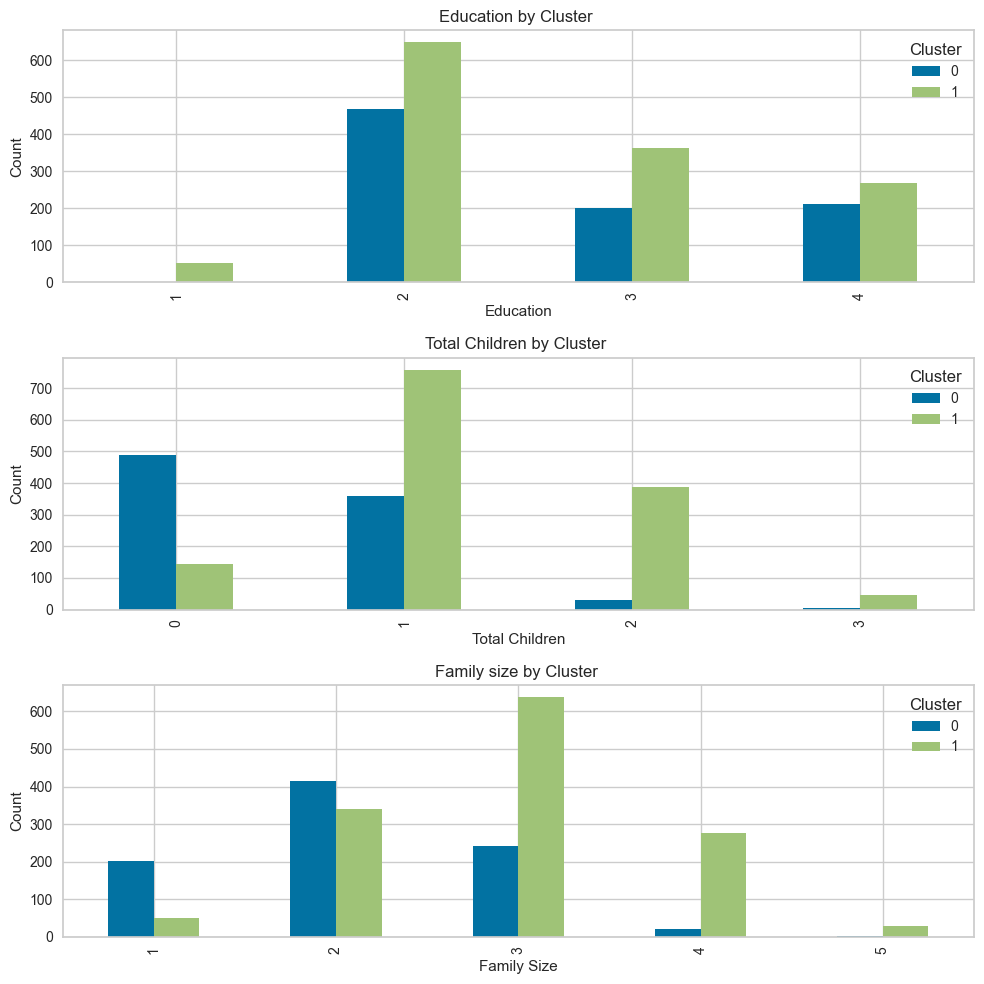

In [335]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

# Plot 'Education' vs 'Cluster'
df_original_1.groupby(['Education_encode', 'Cluster']).size().unstack().plot(kind='bar', ax=axs[0])
axs[0].set_title('Education by Cluster ')

# Plot 'Total_children' vs 'Cluster'
df_original_1.groupby(['Total_chil', 'Cluster']).size().unstack().plot(kind='bar', ax=axs[1])
axs[1].set_title('Total Children by Cluster ')

# Plot 'Family_size' vs 'Cluster'
df_original_1.groupby(['Family_size', 'Cluster']).size().unstack().plot(kind='bar', ax=axs[2])
axs[2].set_title('Family size by Cluster ')

# Set x-axis labels
axs[0].set_xlabel('Education')
axs[1].set_xlabel('Total Children')
axs[2].set_xlabel('Family Size')

# Set y-axis labels
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()